In [35]:
import numpy as np
import pandas as pd
from collections import Counter

In [232]:
# Define the KNN class
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        """ 
            X: numpy.ndarray of X_test
        """
        predictions = []
        for i, row in enumerate(X):
            # print(f"predicting {i} out of {len(X)}")
            predictions.append(self.predict_single_point(row))
            # print("====================================================")
        return np.array(predictions)
    
    def predict_single_point(self, x):
        # compute distances from the test point to all training points
        distances = [self.compute_distance(x, x_train_point) for x_train_point in self.X_train]
        
        # get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        # print(f"THE K INDICES ARE {k_indices}")

        # get the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # return the most common label among the nearest neighbors
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
        
        # print(f"predicted: {most_common_label}")
        
        return most_common_label

    def compute_distance(self, X1, X2):
        # TODO: Implement distance computation based on self.distance_metric
        # Hint: Use numpy operations for efficient computation

        if self.distance_metric == 'euclidean':
            return np.linalg.norm(X1 - X2)
        
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(X1 - X2))

        elif self.distance_metric == 'cosine':
            dot_product = np.dot(X1, X2)
            norm_product = np.linalg.norm(X1) * np.linalg.norm(X2)
            return 1 - dot_product / norm_product 
        
        elif self.distance_metric == 'minkowski':
            return np.sum(np.abs(X1 - X2) ** 2) ** (1 / 2)
        
        elif self.distance_metric == 'hamming':
            return np.sum(X1 != X2)
        

In [233]:
# Define data preprocessing function

def standard_scaler(data, columns):
    """
        Data is a pandas df, columns is column indices that are int/float
        Formula: (X - mean) / std
    """
    scaled_data = data.copy()
    for col in columns:
        mean = scaled_data[col].mean()
        std = scaled_data[col].std()
        scaled_data[col] = (scaled_data[col] - mean) / std
    return scaled_data

def one_hot_encode(data, columns):
    """
        Data is a pandas df, columns is column indices that are int/float
    """
    return pd.get_dummies(data, columns=columns, drop_first=True)

def preprocess_data(train_data, test_data):
    """
        train_data is full train data as pandas df
        same for test_data

        Apply standardscalar to num
        and categorical encoder to int
    """

    X_train = train_data.iloc[:, 3:13]
    y_train = train_data['Exited']

    X_test = test_data.iloc[:, 3:13]

    # SELECT NUM/CAT FOR TRAINING
    numerical_cols_train = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols_train = X_train.select_dtypes(include=['object']).columns

    # SELECT NUM/CAT FOR TESTING
    numerical_cols_test = X_test.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols_test = X_test.select_dtypes(include=['object']).columns
    
    X_train_scaled = standard_scaler(X_train, numerical_cols_train)
    X_test_scaled = standard_scaler(X_test, numerical_cols_test)

    X_train_processed = one_hot_encode(X_train_scaled, categorical_cols_train)
    X_test_processed = one_hot_encode(X_test_scaled, categorical_cols_test)
    
    return X_train_processed.values, y_train.values, X_test_processed.values

In [182]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
preprocess_data(train_data, test_data)[0]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.170812,-0.578192,1.066915,0.990459,-1.102312,0.529829,1.022213,1.296669,True,False,True
1,0.060597,-1.069157,0.709002,-0.727682,0.773857,-1.887275,-0.978204,0.976132,False,False,True
2,0.708111,-0.700933,-1.438477,-0.727682,0.773857,0.529829,-0.978204,-1.598851,False,False,True
3,0.377466,1.753888,1.424828,0.650193,-1.102312,-1.887275,-0.978204,0.174050,False,False,True
4,0.225920,0.526477,0.351089,1.440448,-1.102312,0.529829,1.022213,-1.018246,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
14995,-0.710909,0.158254,0.351089,-0.727682,0.773857,0.529829,-0.978204,-1.724508,False,True,True
14996,-0.435371,-1.437380,-0.364737,-0.727682,0.773857,0.529829,-0.978204,-0.780273,False,False,True
14997,-0.669578,1.999370,1.424828,-0.727682,0.773857,-1.887275,1.022213,0.138294,False,False,False
14998,0.804549,-0.823674,-1.438477,1.450567,-1.102312,-1.887275,1.022213,-2.039056,True,False,True


In [172]:
# Define cross-validation function

def manual_kfold_split(X, y, n_splits=5):
    indices = np.arange(len(X))
    fold_size = len(X) // n_splits
    folds = []

    for i in range(n_splits):
        start = i * fold_size
        if i == n_splits - 1:
            end = len(X)
        else:
            end = (i + 1) * fold_size

        val_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])

        folds.append((train_indices, val_indices))
    
    return folds

def compute_roc_auc(y_true, y_pred):
    """
        y_true: Array of actual class
        y_pred: Array of predicted class
    """
    # True positives, false positives, true negatives, false negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0 

    auc = (1 + TPR - FPR) / 2

    return auc

def cross_validate(X, y, knn, n_splits=5):
    # TODO: Implement cross-validation
    # Compute ROC AUC scores
    """
        X: training data features
        y: train data results
        knn: knn object 
        n_splits: number of folds for cross-validation
    """

    # split data
    folds = manual_kfold_split(X, y, n_splits)
    cv_scores = []

    for train_index, val_index in folds:
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        knn.fit(X_train, y_train)

        y_val_pred = knn.predict(X_val)

        auc_score = compute_roc_auc(y_val, y_val_pred)
        cv_scores.append(auc_score)

    mean_auc = np.mean(cv_scores)
    
    return mean_auc

In [200]:
# Make predictions on test
X_train, y_train, X_test = preprocess_data(train_data, test_data)

def make_prediction(n_neighbors, X_train, y_train):

    knn = KNN(k=n_neighbors, distance_metric='euclidean')
    knn.fit(X_train[:100], y_train[:100])

    predictions = knn.predict(X_test)
    return predictions

In [201]:
make_prediction(5, X_train, y_train)

array([0., 0., 0., ..., 0., 0., 0.])

In [218]:
# Perform cross-validation
knn = KNN(k=5, distance_metric='minkowski')
knn.fit(X_train, y_train)

cv_scores = cross_validate(X_train[:1000], y_train[:1000], knn)

print("Cross-validation scores:", cv_scores)

Cross-validation scores: 0.7541379063441267


In [204]:
n_neighbors_values = range(1, 50)
all_cv_scores = []

for n_neighbors in n_neighbors_values:
    knn = KNN(k=n_neighbors, distance_metric='euclidean')
    knn.fit(X_train, y_train)

    cv_score = cross_validate(X_train[:1000], y_train[:1000], knn)
    all_cv_scores.append(cv_score)
    print(f"cv scores for {n_neighbors} is {cv_score}")

print(f"best result is {n_neighbors_values[np.argmax(all_cv_scores)]} neighbors")

cv scores for 1 is 0.7358824911889486
cv scores for 2 is 0.7358824911889486
cv scores for 3 is 0.738076576159838
cv scores for 4 is 0.7447870144522485
cv scores for 5 is 0.7541379063441267
cv scores for 6 is 0.7395440117441825
cv scores for 7 is 0.7237811729741781
cv scores for 8 is 0.7342569105004643
cv scores for 9 is 0.714410556566554
cv scores for 10 is 0.7374420040870776
cv scores for 11 is 0.7171243607644894
cv scores for 12 is 0.7201391998465481
cv scores for 13 is 0.7168185881397398
cv scores for 14 is 0.7156681608335695
cv scores for 15 is 0.7129442154409684
cv scores for 16 is 0.7074750442471596
cv scores for 17 is 0.703484270210619
cv scores for 18 is 0.7003710913503137
cv scores for 19 is 0.6926083241416213
cv scores for 20 is 0.6955200550358084


KeyboardInterrupt: 

In [135]:
# try using manhattan distance?
n_neighbors_values = range(1, 50)
all_cv_scores = []

for n_neighbors in n_neighbors_values:
    knn = KNN(k=n_neighbors, distance_metric='manhattan')
    knn.fit(X_train, y_train)

    cv_score = cross_validate(X_train[:1000], y_train[:1000], knn)
    all_cv_scores.append(cv_score)
    print(f"cv scores for {n_neighbors} is {cv_score}")

print(f"best result is {n_neighbors_values[np.argmax(all_cv_scores)]} neighbors")

cv scores for 5 is 0.718238024593228
cv scores for 6 is 0.7394437367368972
cv scores for 7 is 0.7279541153949802
cv scores for 8 is 0.7253251280921356
cv scores for 9 is 0.7239500577903594
cv scores for 10 is 0.7160923356485851
cv scores for 11 is 0.71576703770447
cv scores for 12 is 0.7111446375399675
cv scores for 13 is 0.7028443224481898
cv scores for 14 is 0.7072409364361872
cv scores for 15 is 0.7096770878126104
cv scores for 16 is 0.7076900477201443
cv scores for 17 is 0.7063609572960061
cv scores for 18 is 0.7015110720022538
cv scores for 19 is 0.7017735945578453
cv scores for 20 is 0.7073521962344506
cv scores for 21 is 0.6936957075325898
cv scores for 22 is 0.7190439255577589
cv scores for 23 is 0.6949287000588832
cv scores for 24 is 0.6984522028577483
cv scores for 25 is 0.6840071053706291
cv scores for 26 is 0.6883115690104151
cv scores for 27 is 0.6859691071871723
cv scores for 28 is 0.6857258993000183
cv scores for 29 is 0.6735516418172309
cv scores for 30 is 0.68789254780

In [219]:
# try using minkowski distance?
n_neighbors_values = range(1, 40)
all_cv_scores = []

for n_neighbors in n_neighbors_values:
    knn = KNN(k=n_neighbors, distance_metric='minkowski')
    knn.fit(X_train, y_train)

    cv_score = cross_validate(X_train[:1000], y_train[:1000], knn)
    all_cv_scores.append(cv_score)
    print(f"cv scores for {n_neighbors} is {cv_score}")

print(f"best result is {n_neighbors_values[np.argmax(all_cv_scores)]} neighbors")


cv scores for 1 is 0.7358824911889486
cv scores for 2 is 0.7358824911889486
cv scores for 3 is 0.738076576159838
cv scores for 4 is 0.7447870144522485
cv scores for 5 is 0.7541379063441267
cv scores for 6 is 0.7395440117441825
cv scores for 7 is 0.7237811729741781
cv scores for 8 is 0.7342569105004643
cv scores for 9 is 0.714410556566554
cv scores for 10 is 0.7374420040870776
cv scores for 11 is 0.7171243607644894
cv scores for 12 is 0.7201391998465481
cv scores for 13 is 0.7168185881397398
cv scores for 14 is 0.7156681608335695
cv scores for 15 is 0.7129442154409684
cv scores for 16 is 0.7074750442471596
cv scores for 17 is 0.703484270210619
cv scores for 18 is 0.7003710913503137
cv scores for 19 is 0.6926083241416213
cv scores for 20 is 0.6955200550358084
cv scores for 21 is 0.6964458164230496
cv scores for 22 is 0.696259110499339
cv scores for 23 is 0.6846106987684782
cv scores for 24 is 0.6922804179328448
cv scores for 25 is 0.6854855461379732
cv scores for 26 is 0.684138070710038


## Balance Dataset

In [205]:
import random
random.seed(1212)

train_data = pd.read_csv("train.csv")
Counter(train_data['Exited'])

train_data_neg = train_data[train_data['Exited'] == 0]
train_data_pos = train_data[train_data['Exited'] == 1]

samples_to_remove = len(train_data_neg) - len(train_data_pos)

rand_index = random.sample(list(train_data_neg['id']), samples_to_remove)

train_data_balanced = train_data[~train_data['id'].isin(rand_index)]
train_data_balanced

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,4,15693637.0,Rizzo,675.0,France,Male,42.0,6.0,129968.67,1.0,1.0,1.0,70563.90,1.0
6,6,15739223.0,Mazzi,592.0,France,Male,61.0,2.0,0.00,2.0,1.0,0.0,114093.73,1.0
7,7,15776921.0,Hsiao,747.0,France,Male,63.0,3.0,0.00,1.0,1.0,0.0,130113.78,1.0
9,9,15782219.0,Goliwe,714.0,Spain,Male,36.0,1.0,0.00,2.0,0.0,0.0,71139.31,0.0
13,13,15804009.0,Trevisan,563.0,Germany,Male,52.0,6.0,142316.14,1.0,1.0,0.0,142331.85,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14977,14977,15660646.0,Bancks,553.0,France,Male,46.0,6.0,0.00,1.0,1.0,1.0,125451.01,1.0
14982,14982,15693906.0,Maclean,619.0,France,Female,35.0,7.0,0.00,1.0,0.0,1.0,153535.56,1.0
14997,14997,15770041.0,Ch'eng,610.0,France,Female,54.0,9.0,0.00,2.0,0.0,1.0,123475.88,1.0
14998,14998,15698028.0,Chia,717.0,Germany,Male,31.0,1.0,130575.26,1.0,0.0,1.0,23861.62,0.0


In [206]:
X_train

array([[0.17081228880244131, -0.5781923314075393, 1.0669152355654827,
        ..., True, False, True],
       [0.060597183406112816, -1.0691566660304144, 0.7090020868093384,
        ..., False, False, True],
       [0.7081109276095428, -0.7009334150632581, -1.438476805727528, ...,
        False, False, True],
       ...,
       [-0.6695778898445635, 1.9993704253625546, 1.4248283843216272, ...,
        False, False, False],
       [0.8045491448313302, -0.8236744987189769, -1.438476805727528, ...,
        True, False, True],
       [0.983648691100364, 0.5264774214939295, 1.4248283843216272, ...,
        False, True, True]], dtype=object)

In [208]:
# Make predictions on test
X_train_balanced, y_train_balanced, X_test = preprocess_data(train_data_balanced, test_data)

def make_prediction(n_neighbors, X_train, y_train):

    knn = KNN(k=n_neighbors, distance_metric='euclidean')
    knn.fit(X_train_balanced[:100], y_train_balanced[:100])

    predictions = knn.predict(X_test)
    return predictions

predictions_balanced = make_prediction(5, X_train_balanced, y_train_balanced)

# Perform cross-validation
knn = KNN(k=5, distance_metric='euclidean')
knn.fit(X_train_balanced, y_train)

cv_scores = cross_validate(X_train_balanced[:1000], y_train_balanced[:1000], knn)

print("Cross-validation scores:", cv_scores)

Cross-validation scores: 0.796381678773088


In [209]:
n_neighbors_values = range(1, 50)
all_cv_scores = []

for n_neighbors in n_neighbors_values:
    knn = KNN(k=n_neighbors, distance_metric='euclidean')
    knn.fit(X_train_balanced, y_train_balanced)

    cv_score = cross_validate(X_train_balanced[:1000], y_train_balanced[:1000], knn)
    all_cv_scores.append(cv_score)
    print(f"cv scores for {n_neighbors} is {cv_score}")

print(f"best result is {n_neighbors_values[np.argmax(all_cv_scores)]} neighbors")

cv scores for 1 is 0.7587379768166812
cv scores for 2 is 0.7587379768166812
cv scores for 3 is 0.7860051218139782
cv scores for 4 is 0.7848117883191423
cv scores for 5 is 0.796381678773088
cv scores for 6 is 0.7999965748291029
cv scores for 7 is 0.8072815193923806
cv scores for 8 is 0.7963958661798161
cv scores for 9 is 0.7993907132554077
cv scores for 10 is 0.7988064145747005
cv scores for 11 is 0.7928565017446847
cv scores for 12 is 0.7994121396254967
cv scores for 13 is 0.7911051350869723
cv scores for 14 is 0.795374322696998
cv scores for 15 is 0.7820718690491231
cv scores for 16 is 0.7894972150493632
cv scores for 17 is 0.7802404802013365
cv scores for 18 is 0.7875258543696313
cv scores for 19 is 0.7792454766308342
cv scores for 20 is 0.7870901969298033
cv scores for 21 is 0.780800593082554
cv scores for 22 is 0.7874892224088378
cv scores for 23 is 0.7860660051366297
cv scores for 24 is 0.79198521906869
cv scores for 25 is 0.7861302720844219
cv scores for 26 is 0.7918984830204404


In [210]:
predictions_balanced = make_prediction(7, X_train_balanced, y_train_balanced)


## Drop some features

In [331]:
train_data_balanced

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,4,15693637.0,Rizzo,675.0,France,Male,42.0,6.0,129968.67,1.0,1.0,1.0,70563.90,1.0
6,6,15739223.0,Mazzi,592.0,France,Male,61.0,2.0,0.00,2.0,1.0,0.0,114093.73,1.0
7,7,15776921.0,Hsiao,747.0,France,Male,63.0,3.0,0.00,1.0,1.0,0.0,130113.78,1.0
9,9,15782219.0,Goliwe,714.0,Spain,Male,36.0,1.0,0.00,2.0,0.0,0.0,71139.31,0.0
13,13,15804009.0,Trevisan,563.0,Germany,Male,52.0,6.0,142316.14,1.0,1.0,0.0,142331.85,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14977,14977,15660646.0,Bancks,553.0,France,Male,46.0,6.0,0.00,1.0,1.0,1.0,125451.01,1.0
14982,14982,15693906.0,Maclean,619.0,France,Female,35.0,7.0,0.00,1.0,0.0,1.0,153535.56,1.0
14997,14997,15770041.0,Ch'eng,610.0,France,Female,54.0,9.0,0.00,2.0,0.0,1.0,123475.88,1.0
14998,14998,15698028.0,Chia,717.0,Germany,Male,31.0,1.0,130575.26,1.0,0.0,1.0,23861.62,0.0


In [294]:
# Define data preprocessing function

def standard_scaler(data, columns):
    """
        Data is a pandas df, columns is column indices that are int/float
        Formula: (X - mean) / std
    """
    scaled_data = data.copy()
    for col in columns:
        mean = scaled_data[col].mean()
        std = scaled_data[col].std()
        scaled_data[col] = (scaled_data[col] - mean) / std
    return scaled_data

def one_hot_encode(data, columns):
    """
        Data is a pandas df, columns is column indices that are int/float
    """
    return pd.get_dummies(data, columns=columns, drop_first=True)

def preprocess_data(train_data, test_data):
    """
        train_data is full train data as pandas df
        same for test_data

        Apply standardscalar to num
        and categorical encoder to int
    """

    X_train = train_data.iloc[:, 3:13]
    y_train = train_data['Exited']

    X_test = test_data.iloc[:, 3:13]

    # SELECT NUM/CAT FOR TRAINING
    numerical_cols_train = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols_train = X_train.select_dtypes(include=['object']).columns

    # SELECT NUM/CAT FOR TESTING
    numerical_cols_test = X_test.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols_test = X_test.select_dtypes(include=['object']).columns
    
    X_train_scaled = standard_scaler(X_train, numerical_cols_train)
    X_test_scaled = standard_scaler(X_test, numerical_cols_test)

    X_train_processed = one_hot_encode(X_train_scaled, categorical_cols_train)
    X_test_processed = one_hot_encode(X_test_scaled, categorical_cols_test)
    
    return X_train_processed, y_train, X_test_processed

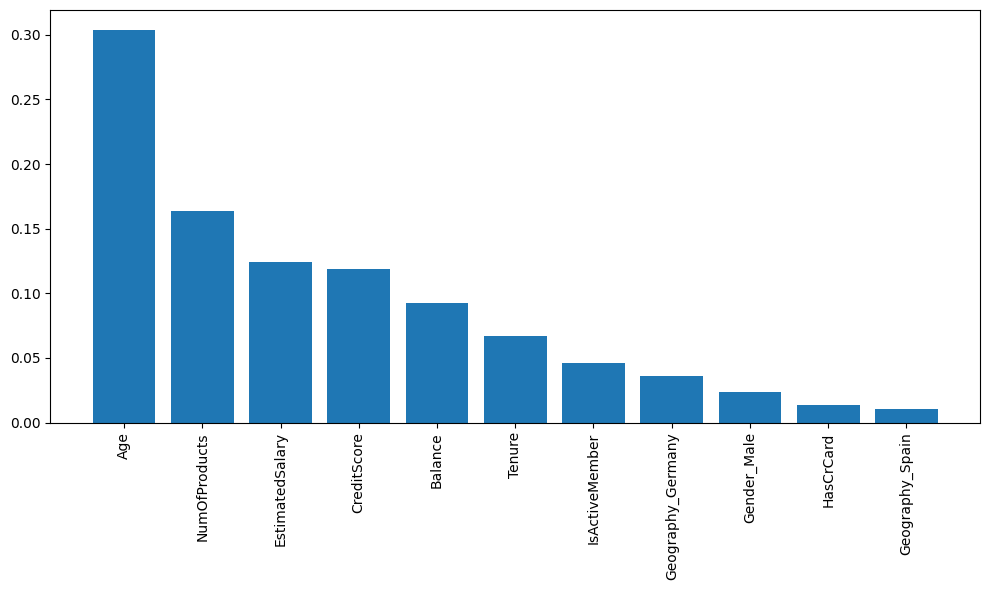

In [274]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

X_train_df, y_train_df, X_test_df = preprocess_data(pd.read_csv("train.csv"), pd.read_csv("test.csv"))

# Fit Random Forest
model = RandomForestClassifier()
model.fit(X_train_df, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X_train_df.columns

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_df.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_df.shape[1]), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


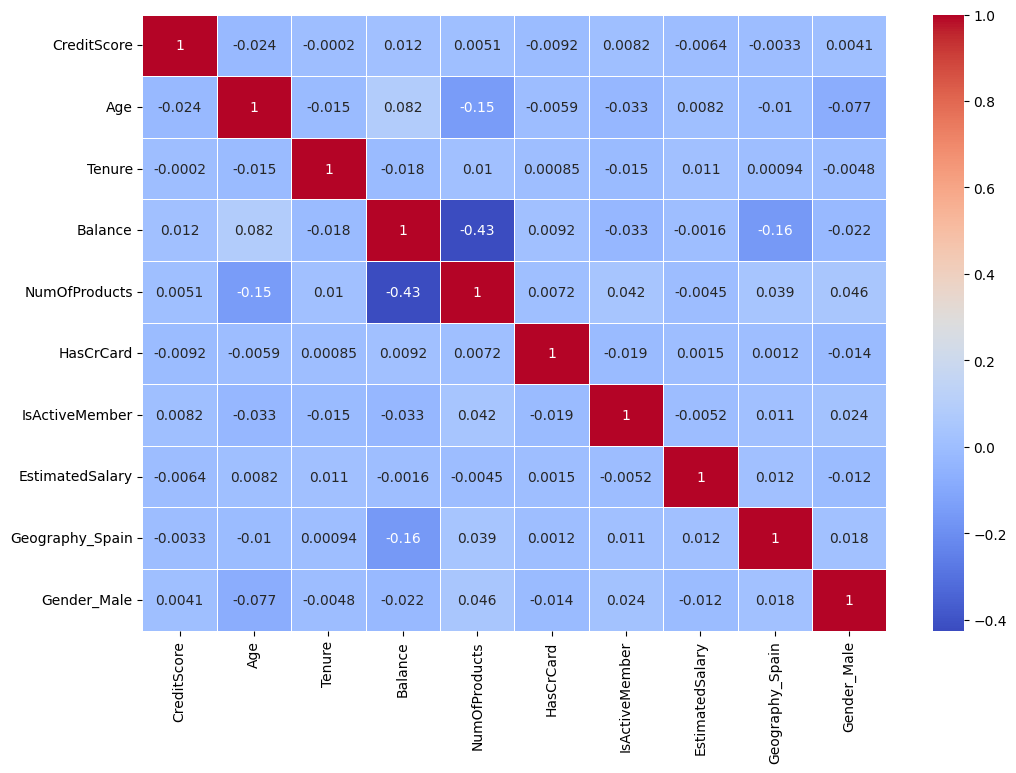

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt

X_train_df = preprocess_data(pd.read_csv("train.csv"), pd.read_csv("test.csv"))[0]
X_train_df = X_train_df.drop(columns=['Geography_Germany'], axis=1)
# Calculate correlation matrix
corr_matrix = X_train_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [304]:
from sklearn.feature_selection import SelectKBest, chi2

X_train_df, y_train_df, X_test_df = preprocess_data(pd.read_csv("train.csv"), pd.read_csv("test.csv"))

X_train_df = pd.read_csv("train.csv").iloc[:,3:13].drop(columns=['Geography', 'Gender'], axis=1)
y_train_df = pd.read_csv("train.csv")['Exited']


# Select top k features
selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X_train_df, y_train_df)

print("Selected features:", selector.get_support(indices=True))


Selected features: [0 1 2 3 4 5 6 7]


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(


In [306]:
selected_features = [feature_names[i] for i in [0, 1, 2, 3, 4, 5, 6, 7]]
selected_features

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [325]:
# Define data preprocessing function

def standard_scaler(data, columns):
    """
        Data is a pandas df, columns is column indices that are int/float
        Formula: (X - mean) / std
    """
    scaled_data = data.copy()
    for col in columns:
        mean = scaled_data[col].mean()
        std = scaled_data[col].std()
        scaled_data[col] = (scaled_data[col] - mean) / std
    return scaled_data

def one_hot_encode(data, columns):
    """
        Data is a pandas df, columns is column indices that are int/float
    """
    return pd.get_dummies(data, columns=columns, drop_first=True)

def preprocess_data(train_data, test_data):
    """
        train_data is full train data as pandas df
        same for test_data

        Apply standardscalar to num
        and categorical encoder to int
    """

    X_train = train_data.iloc[:, 3:13]
    y_train = train_data['Exited']

    X_test = test_data.iloc[:, 3:13]

    # SELECT NUM/CAT FOR TRAINING
    numerical_cols_train = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols_train = X_train.select_dtypes(include=['object']).columns

    # SELECT NUM/CAT FOR TESTING
    numerical_cols_test = X_test.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols_test = X_test.select_dtypes(include=['object']).columns
    
    X_train_scaled = standard_scaler(X_train, numerical_cols_train)
    X_test_scaled = standard_scaler(X_test, numerical_cols_test)

    X_train_processed = one_hot_encode(X_train_scaled, categorical_cols_train)[['Age', 'NumOfProducts']]
    X_test_processed = one_hot_encode(X_test_scaled, categorical_cols_test)[['Age', 'NumOfProducts']]
    
    return X_train_processed.values, y_train.values, X_test_processed.values

In [339]:
# Make predictions on test
X_train_new, y_train_new, X_test = preprocess_data(train_data_balanced, pd.read_csv("test.csv"))

def make_prediction(n_neighbors, X_train, y_train):

    knn = KNN(k=n_neighbors, distance_metric='euclidean')
    knn.fit(X_train, y_train)

    predictions = knn.predict(X_test)
    return predictions

In [343]:
Counter(make_prediction(14, X_train_new, y_train_new))

Counter({np.float64(0.0): 6518, np.float64(1.0): 3482})

In [335]:
# Perform cross-validation
knn = KNN(k=5, distance_metric='euclidean')
knn.fit(X_train_new, y_train_new)

cv_scores = cross_validate(X_train_new[:1000], y_train_new[:1000], knn)

print("Cross-validation scores:", cv_scores)

Cross-validation scores: 0.8107581049811319


In [336]:
X_train_new.shape

(6066, 2)

In [337]:
# try using minkowski distance?
n_neighbors_values = range(1, 30)
all_cv_scores = []

for n_neighbors in n_neighbors_values:
    knn = KNN(k=n_neighbors, distance_metric='euclidean')
    knn.fit(X_train_new, y_train_new)

    cv_score = cross_validate(X_train_new[:1000], y_train_new[:1000], knn)
    all_cv_scores.append(cv_score)
    print(f"cv scores for {n_neighbors} is {cv_score}")

print(f"best result is {n_neighbors_values[np.argmax(all_cv_scores)]} neighbors")


cv scores for 1 is 0.7552634104038539
cv scores for 2 is 0.7552634104038539
cv scores for 3 is 0.8029672952049938
cv scores for 4 is 0.8003578809591725
cv scores for 5 is 0.8107581049811319
cv scores for 6 is 0.7902620294559879
cv scores for 7 is 0.7980820636217805
cv scores for 8 is 0.8063945918826414
cv scores for 9 is 0.8038221615433793
cv scores for 10 is 0.8146995827876516
cv scores for 11 is 0.809298927449705
cv scores for 12 is 0.8193521304748483
cv scores for 13 is 0.8065789564583259
cv scores for 14 is 0.8198602973899491
cv scores for 15 is 0.8055390456012042
cv scores for 16 is 0.8162479210947767
cv scores for 17 is 0.8188078391922723
cv scores for 18 is 0.8124267951297984
cv scores for 19 is 0.813157997364946
cv scores for 20 is 0.8124036880207608
cv scores for 21 is 0.8122143038977192
cv scores for 22 is 0.8084570680677178
cv scores for 23 is 0.8094004642941328
cv scores for 24 is 0.8094004642941328
cv scores for 25 is 0.8166847014379315
cv scores for 26 is 0.81750371628432

## Save test predictions

In [341]:
predictions = make_prediction(14, X_train_new, y_train_new)

In [342]:
# Save test predictions
pd.DataFrame({'id': pd.read_csv('test.csv')['id'], 'Exited': predictions_balanced}).to_csv('submissions.csv', index=False)